<a href="https://colab.research.google.com/github/Jaiveer-raghuwanshi/Data-Science-Project/blob/main/Model%20Evaluation%20%26%20Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK : 4 -- Model Evaluation & Deployment
# Goal: Evaluate model performance and deploy it for real-world use.

STEP 0 — Install & imports (Colab)

In [69]:
!pip install -q streamlit pyngrok scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import pickle
import json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


STEP 1 — Load data, split, train a model

In [70]:
# Load a simple classification dataset
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target
feature_names = X.columns.tolist()
target_names = iris.target_names.tolist()

# Train/val split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline: scale -> model
clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight=None
    ))
])

# Train
clf.fit(X_train, y_train)

# Predictions on test
y_pred = clf.predict(X_test)


STEP 2 — Evaluate the model (Accuracy, Precision, Recall, F1)

Classification Metrics
----------------------
Accuracy : 0.9000
Precision: 0.9024
Recall   : 0.9000
F1-score : 0.8997

Detailed Classification Report
------------------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.82      0.90      0.86        10
   virginica       0.89      0.80      0.84        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



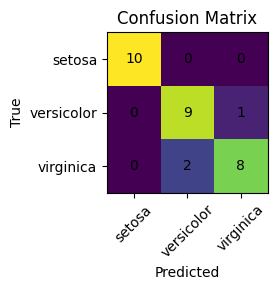

In [71]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("Classification Metrics")
print("----------------------")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print("Detailed Classification Report")
print("------------------------------")
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

# Confusion Matrix plot (optional)
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(4,3))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(len(target_names)), labels=target_names, rotation=45)
plt.yticks(ticks=range(len(target_names)), labels=target_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()


STEP 3 — Save the trained model with pickle

In [72]:
# Compute simple per-feature stats for nicer Streamlit inputs
feature_stats = {
    col: {
        "min": float(X_train[col].min()),
        "max": float(X_train[col].max()),
        "mean": float(X_train[col].mean())
    }
    for col in feature_names
}

artifact = {
    "model": clf,
    "feature_names": feature_names,
    "target_names": target_names,
    "feature_stats": feature_stats
}

with open("artifact.pkl", "wb") as f:
    pickle.dump(artifact, f)

print("✅ Saved artifact.pkl (model + metadata)")


✅ Saved artifact.pkl (model + metadata)


STEP 4 — Quick local prediction test (sanity check)

In [73]:
with open("artifact.pkl", "rb") as f:
    art = pickle.load(f)

pipe = art["model"]
feat = art["feature_names"]

# Build one example from the test set
example = X_test.iloc[[0]].values
pred = pipe.predict(example)[0]
print("Test example features:", dict(zip(feat, X_test.iloc[0].to_list())))
print("Predicted class:", target_names[pred])


Test example features: {'sepal length (cm)': 4.4, 'sepal width (cm)': 3.0, 'petal length (cm)': 1.3, 'petal width (cm)': 0.2}
Predicted class: setosa


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


STEP 5 — Create app.py (Streamlit UI)

In [74]:
%%writefile app.py
import streamlit as st
import pickle
import numpy as np
import pandas as pd

st.set_page_config(page_title="Data-Driven Decision System", page_icon="📊")

@st.cache_resource
def load_artifact():
    with open("artifact.pkl", "rb") as f:
        return pickle.load(f)

artifact = load_artifact()
model = artifact["model"]
feature_names = artifact["feature_names"]
target_names = artifact["target_names"]
feature_stats = artifact["feature_stats"]

st.title("📊 Data-Driven Decision Making System")
st.caption("Sklearn model deployed with Streamlit")

st.subheader("Single Prediction")
inputs = []
cols = st.columns(min(4, len(feature_names)))
for i, name in enumerate(feature_names):
    stats = feature_stats.get(name, {})
    minv = stats.get("min", 0.0)
    maxv = stats.get("max", 10.0)
    meanv = stats.get("mean", (minv + maxv) / 2)
    with cols[i % len(cols)]:
        val = st.number_input(
            label=f"{name}",
            min_value=float(minv),
            max_value=float(maxv) if maxv > minv else float(minv + 100),
            value=float(meanv),
            step=0.1,
            format="%.4f",
            help=f"Range approx: [{minv:.4f}, {maxv:.4f}]"
        )
        inputs.append(val)

if st.button("Predict"):
    X = np.array([inputs])
    pred = model.predict(X)[0]
    st.success(f"Prediction: {target_names[pred] if target_names else pred}")

    # Probabilities if available
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)[0]
        prob_df = pd.DataFrame({
            "class": target_names if target_names else list(range(len(probs))),
            "probability": probs
        }).sort_values("probability", ascending=False)
        st.write("Class probabilities:")
        st.dataframe(prob_df, use_container_width=True)

st.divider()
st.subheader("Batch Prediction (CSV)")
st.caption("Upload a CSV with *exactly* these columns, in any order:")
st.code(", ".join(feature_names))

uploaded = st.file_uploader("Upload CSV", type=["csv"])
if uploaded is not None:
    try:
        df = pd.read_csv(uploaded)
        # Reorder / subset to required features
        df_model = df[feature_names].copy()
        preds = model.predict(df_model.values)
        out = df.copy()
        out["prediction"] = [target_names[p] if target_names else p for p in preds]
        st.write("Preview with predictions:")
        st.dataframe(out.head(), use_container_width=True)
        # Download
        csv = out.to_csv(index=False).encode("utf-8")
        st.download_button("Download predictions CSV", csv, file_name="predictions.csv")
    except Exception as e:
        st.error(f"Error: {e}")


Overwriting app.py


STEP 6 — Run Streamlit in Colab with ngrok

In [75]:
from pyngrok import ngrok

# Replace with YOUR actual token
ngrok.set_auth_token("31LjUfAPzHhsLqGHwNWCsXIaX27_5TStGPvWMRUGgZJQ2SzCc")


In [68]:
!streamlit run app.py &

# Connect to Streamlit via ngrok
public_url = ngrok.connect(8501)
print("🚀 Open your Streamlit app here:", public_url)





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.129.180:8501

  Stopping...
🚀 Open your Streamlit app here: NgrokTunnel: "https://237fc24d376f.ngrok-free.app" -> "http://localhost:8501"


In [78]:
# 1. Install dependencies
!pip install streamlit pyngrok -q

# 2. Import ngrok and set auth token (replace with your token)
from pyngrok import ngrok
ngrok.set_auth_token("YOUR_NGROK_AUTH_TOKEN")

# 3. Run Streamlit in background
!nohup streamlit run app.py --server.port 8501 >/dev/null 2>&1 &

# 4. Create ngrok tunnel to port 8501
public_url = ngrok.connect(8501)
print("🚀 Streamlit App URL:", public_url)


🚀 Streamlit App URL: NgrokTunnel: "https://a06ef9ff49f5.ngrok-free.app" -> "http://localhost:8501"
